Set up the PYTHONPATH so it can find the python modules we'll be using.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.pardir, 'python'))

Import the geometry module

In [2]:
import geometry as geo

Set the base resolution that will be used throughout

In [3]:
minres = 10.0

In [4]:
geo.SlabSpline?

Init signature: geo.SlabSpline(xs, ys, res=None, name=None, sid=None, bctype='natural')
Docstring:      <no docstring>
File:           ~/repos/github/cianwilson/fenicsx_subduction/python/geometry.py
Type:           type
Subclasses:     

In [5]:
slab = geo.SlabSpline([0.0, 140.0, 240.0, 400.0], [0.0, -70.0, -120.0, -200.0], 
                       res=[2*minres, 1*minres, 1*minres, 6*minres], sid=1, name="Slab")
print(len(slab.points))

4


/Users/cwilson/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [6]:
# add partial coupling depths
slab.addpoint(80, "Slab::PartialCouplingDepth", res=1*minres)
slab.addpoint(82.5, "Slab::FullCouplingDepth", res=1*minres)
print(len(slab.points))

6


In [7]:
geo.SubductionGeometry?

Init signature: geo.SubductionGeometry(slab_spline, **kwargs)
Docstring:      <no docstring>
Init docstring:
Initialize the subduction geometry with the current values of:
* slab_spline:          SlabSpline object describing the slab
* coast_distance (>=0): distance from the trench that the coast is located,
                        does nothing if ==0.0 and the trench is at 0.0 depth
* extra_width (>=0):    extra width of domain beyond the final slab point,
                        does nothing if ==0.0
* slab_side_sid:        surface id of vertical side on slab side of domain
* wedge_side_sid:       surface id of vertical side on wedge side of domain
* slab_base_sid:        surface id of base of slab region of domain
* wedge_base_sid:       surface id of base of wedge region of domain,
                        only used if extra_width > 0.0
* coast_sid:            surface id of line between trench and coast,
                        only used if coast_distance > 0.0 or the slab trench is

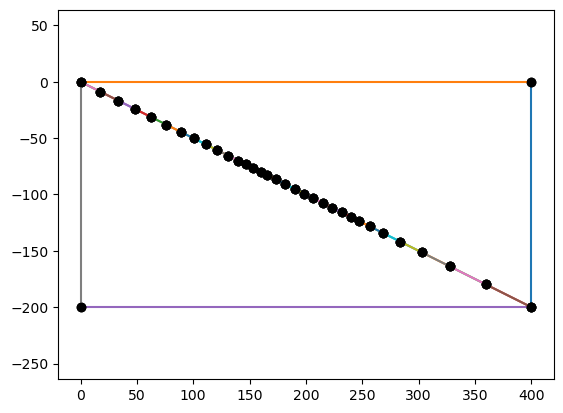

In [8]:
geom = geo.SubductionGeometry(slab, slab_rid=1, wedge_rid=2, 
                                    slab_side_sid=2, wedge_side_sid=3, slab_base_sid=7, 
                                    wedge_base_sid=8, coast_sid=11, top_sid=12,
                                    wedge_top_res=4*minres, slab_base_res=6*minres)
geom.plot()

['WedgeSide', 'LowerCrust']
7


/Users/cwilson/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


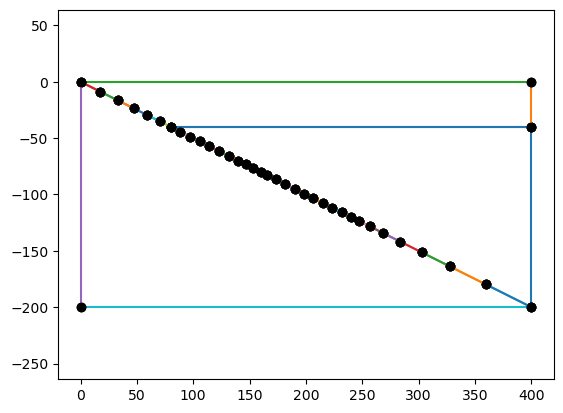

In [9]:
geom.addcrustlayer(40, "LowerCrust", sid=9, rid=3, slab_res=1*minres, side_res=4*minres, side_sid=5)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
print(len(slab.points))
geom.plot()

['WedgeSide', 'LowerCrust', 'UpperCrust']


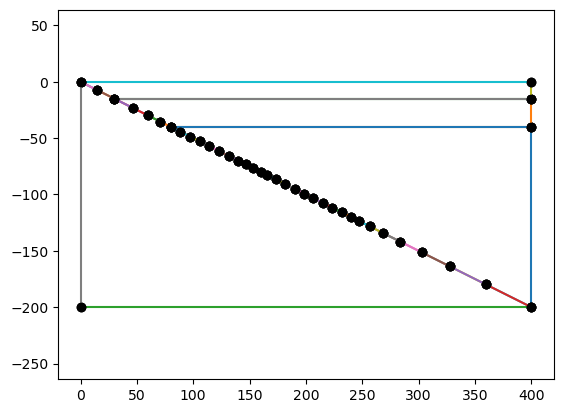

In [10]:
geom.addcrustlayer(15,"UpperCrust", sid=10, rid=4, slab_res= 2*minres, side_res=4*minres, side_sid=6)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
geom.plot()

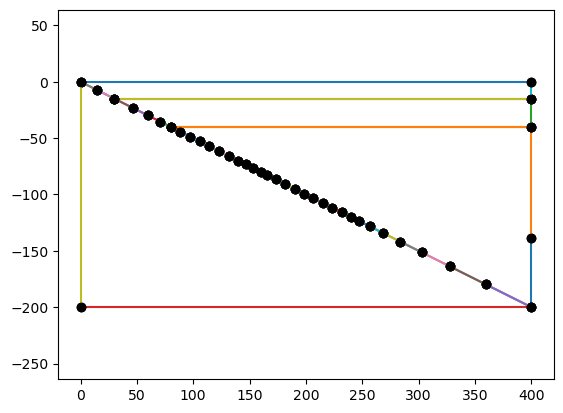

In [11]:
geom.addwedgesidepoint(139, "WedgeSide::InOut", line_name="UpperWedgeSide", res=4*minres, sid=4)
geom.plot()

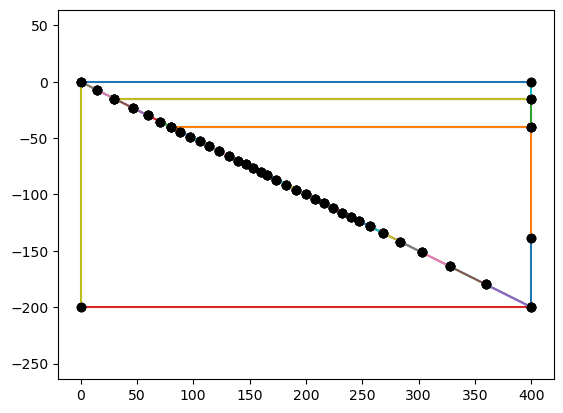

In [12]:
geom.addslabpoint(100, "Slab::DetectorPoint", res=1*minres, sid=1)
geom.plot()

In [13]:
mesh, ct, ft = geom.generatemesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 60%] Meshing curve 24 (Line)
I

In [14]:
import dolfinx
import numpy as np

V = dolfinx.fem.FunctionSpace(mesh, ("CG", 2))

In [15]:
all_slab_dofs = dolfinx.fem.locate_dofs_topological(V, 2, ct.find(1))
all_slab_dofs.size

528

In [16]:
all_wedge_dofs = dolfinx.fem.locate_dofs_topological(V, 2, ct.find(2))
all_wedge_dofs.size

437

In [17]:
slab_surface_dofs = dolfinx.fem.locate_dofs_topological(V, 1, ft.find(1))
slab_surface_dofs.size

69

In [18]:
slab_dofs = np.asarray([dof for dof in all_slab_dofs if dof not in slab_surface_dofs])
slab_dofs.size

459

In [19]:
wedge_dofs = np.asarray([dof for dof in all_wedge_dofs if dof not in slab_surface_dofs])
wedge_dofs.size

380